<h1>Coursera Andrew NG Machine Learning Course Week 4 in Python</h1>
<p>We will implement one-vs-all logistic regression and neural networks to recognize hand-written digits. We will use logistic regression and neural networks to recognize handwritten digits (from 0 to 9). Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes) on mail envelopes to recognizing amounts written on bank checks.</p>

<h3>Importing packages</h3>
<ul>
    <li>NumPy, for vectorized calculations</li>
    <li>Matplotlib, for data visualization</li>
    <li>Scipy's loadmat function, for loading MATLAB files</li>
    <li>Scipy's fmin_tnc function, for advanced optimization</li>
</ul>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.optimize import fmin_tnc

<h2>Multi-class Classification</h2>
<p>In the first part, we will extend our previous implemention of logistic regression and apply it to one-vs-all classification.</p>

<h3>Loading the dataset</h3>
<p>You are given a data set in ex3data1.mat that contains 5000 training exam- ples of handwritten digits.2 The .mat format means that that the data has been saved in a native Octave/MATLAB matrix format, instead of a text (ASCII) format like a csv-file.</p>
<p>These matrices can be read directly into your program by using Scipy.io's loadmat() function. After loading, these matrices are stored in a Python dictionary and can be fetched using the get() method. The matrices of the correct dimensions and values will appear in your program’s memory and stored in respective variables.</p>
<p>There are 5000 training examples in 'ex3data1.mat', where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix X. This gives us a 5000 by 400 matrix X where every row is a training example for a handwritten digit image.</p>
<p>The second part of the training set is a 5000-dimensional vector y that contains labels for the training set. To make things more compatible with Octave/MATLAB indexing, where there is no zero index, we have mapped the digit zero to the value ten. Therefore, a “0” digit is labeled as “10”, while the digits “1” to “9” are labeled as “1” to “9” in their natural order.</p>

In [2]:
dataset = loadmat('ex3data1.mat')
features = dataset.get('X')
labels = dataset.get('y').flatten()
labels[labels == 10] = 0
print(features.shape)
print(labels.shape)

(5000, 400)
(5000,)


<h3>Visualizing the data</h3>
<p>The below code randomly selects selects 100 rows from X and passes those rows to the 'displayData' function. This function maps each row to a 20 pixel by 20 pixel grayscale image and displays the images together using Matplotlib.</p>

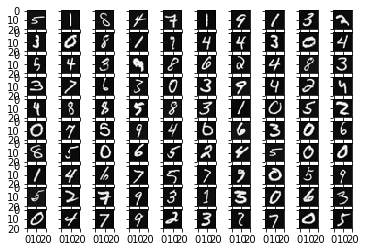

In [3]:
def displayData(X):
    fig, ax = plt.subplots(10,10,sharex=True,sharey=True)
    img_num = 0
    for i in range(10):
        for j in range(10):
            # Convert column vector into 20x20 pixel matrix
            # You have to transpose to display correctly
            img = X[img_num,:].reshape(20,20).T
            ax[i][j].imshow(img,cmap='gray')
            img_num += 1
    plt.show()


# Randomly select 100 datapoints to display
random_indices = np.random.randint(0,len(features),100)
sampleImages = features[random_indices,:] 
displayData(sampleImages)

<h3>Adding 1s to the feature matrix</h3>
<p>To easily vectorize our logistic regression computations, we will add a column of 1s to our feature matrix so as to easily compute matrix multiplications.</p>

In [4]:
features = np.column_stack((np.ones(features.shape[0]), features))
print(features.shape)

(5000, 401)


<h3>Vectorizing Logistic Regression</h3>
<p>We will begin by writing a vectorized version of the cost function. Recall that in (unregularized) logistic regression, the cost function is : </p>
<img src="https://camo.githubusercontent.com/981b4d141dd564974caec19884c514e75a9b3fb1/68747470733a2f2f63616d6f2e67697468756275736572636f6e74656e742e636f6d2f656635346434666134353533633266613836343365346632323934326535636664343837306235302f36383734373437303733336132663266366336383336326536373666366636373663363537353733363537323633366636653734363536653734326536333666366432663438366336623737363634373730333934633462373934363330363636363335343435353461346235323637373735353661373032643737363833313665343936623534343133323638346334633735373034393531343434353635356634313338346434333634363937613433343237383465333536623635373036313334376134323665373633363633366237303334333435613535366336623462333236333331373436643733326434373637343233353636343334323434353933313466373233383466363534653537346433333433346135613665343834353532333134373337373034623735333537383664343334383664343136643633353633373737" />
<p>To compute each element in the summation, we have to compute h<sub> θ </sub>(x(<sup> i </sup>)) for every example i, where h (x(<sup> i </sup>)) = g(θ<sup>T</sup> x(<sup> i </sup>)) and g(z) = 1 / (1 + e<sup> -z</sup>) is the sigmoid function. It turns out that we can compute this quickly for all our examples by using matrix multiplication.</p>
<p>Recall that the gradient of the (unregularized) logistic regression cost is a vector where the jth element is defined as :</p><br>
∂J / ∂θ<sub>j</sub>  = (1 / 􏰉m) * 􏰄sum from j = 1 to m {(h<sub>θ</sub>(x(<sup> i </sup>)) − y(<sup> i </sup>)).x<sub> j </sub>(<sup> i </sup>)􏰅 }<br>

In [5]:
def sigmoid_function(z):
    return 1 / (1 + np.exp(-z))

def cost_function(theta, x, y):
    m = y.shape[0]
    h = sigmoid_function(np.dot(x, theta))
    return (-1 / m) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))

def gradient(theta, x, y):
    m = y.shape[0]
    h = sigmoid_function(np.dot(x, theta))
    error = h - y
    return (1 / m) * np.dot(x.T, error)
    
theta = np.zeros(features.shape[1])
print(cost_function(theta, features, labels))
print(gradient(theta, features, labels).shape)

142.64968975923674
(401,)


<h3>Vectorizing Regularized Logistic Regression</h3>
<p>
After you have implemented vectorization for logistic regression, you will now add regularization to the cost function. Recall that for regularized logistic regression, the cost function is defined as :</p>
<img src="https://camo.githubusercontent.com/4bce1643fa5b5d3f99e28aceb8afec7112bcec23/687474703a2f2f7777772e686f6c65686f7573652e6f72672f6d6c636c6173732f30375f526567756c6172697a6174696f6e5f66696c65732f496d6167652532305b355d2e706e67" />
<p>Correspondingly, the partial derivative of regularized logistic regression cost for θj is defined as : </p>
<img src="https://camo.githubusercontent.com/9467142575f2dffcea3cfe44a625da17b8251ed4/68747470733a2f2f69302e77702e636f6d2f7777772e736369656e636570726f672e636f6d2f77702d636f6e74656e742f75706c6f6164732f323031372f30312f6772616469656e745f726567756c6172697a65642e706e673f726573697a653d363030253243313733" />

In [6]:
def regularized_cost_function(theta, x, y, lamda):
    m = y.shape[0]
    cost_normal = cost_function(theta, x, y)
    regularization_term = (lamda / (2 * m)) * np.sum(theta[1:] ** 2)
    return (cost_normal + regularization_term)

def regularized_gradient(theta, x, y, lamda):
    m = y.shape[0]
    grad = gradient(theta, x, y)
    grad[1:] = grad[1:] + ((lamda / m) * theta[1:])
    return grad

print(regularized_cost_function(theta, features, labels, 1))
print(regularized_gradient(theta, features, labels, 1).shape)

142.64968975923674
(401,)


<h3>One v/s All Classifier</h3>
<p>In this part, we will implement one-vs-all classification by training multiple regularized logistic regression classifiers, one for each of the K classes in our dataset (Figure 1). In the handwritten digits dataset, K = 10.</p>
<p>We here write code which trains one classifier for each class. In particular, our code returns all the classifier parameters in a matrix Θ ∈ R<sup>K × (N+1)</sup> , where each row of Θ corresponds to the learned logistic regression parameters for one class. We use a “for”-loop from 1 to K, training each classifier independently.</p>
<p>When training the classifier for class k ∈ {1,...,K}, we want a m-dimensional vector of labels y, where y<sub>j</sub> ∈ 0,1 indicates whether the j-th training instance belongs to class k (y<sub>j</sub> = 1), or if it belongs to a different class (y<sub>j</sub> = 0).</p>
<p>Furthermore, you will be using fmin_tnc for optimizing the parameters.</p>

In [7]:
def logistic_classifier(x, y, num_classes):
    lamda = 1
    num_parameters = x.shape[1]
    theta = np.zeros((num_parameters, num_classes))
    for digit in range(num_classes):
        outcome = np.array(y == digit).astype(int)
        init_theta = theta[:,digit]
        results = fmin_tnc(func=regularized_cost_function, x0=init_theta, fprime=regularized_gradient, args=(x,outcome,lamda))
        theta[:,digit] = results[0]
    return theta

theta = logistic_classifier(features, labels, 10)
print(theta.shape)

(401, 10)


<h3>Accuracy of our One-vs-All classifier</h3>
<p>After training your one-vs-all classifier, you can now use it to predict the digit contained in a given image. For each input, we compute the “probability” that it belongs to each class using the trained logistic regression classifiers. Our one-vs-all prediction function will pick the class for which the corresponding logistic regression classifier outputs the highest probability and return the class label (1, 2,..., or K) as the prediction for the input example.</p>

In [8]:
def accuracy(theta, x, y):
    probabilities = np.dot(x, theta)
    predictions = np.argmax(probabilities, axis=1)
    accuracy = np.mean(predictions == y) * 100
    return accuracy

print("Accuracy (in %) : ", accuracy(theta, features, labels))

Accuracy (in %) :  94.46


<h2>Neural Networks</h2>
<p>In the previous part, we implemented multi-class logistic re-gression to recognize handwritten digits. However, logistic regression cannot form more complex hypotheses as it is only a linear classifier.</p>
<p>In this part, we implement a neural network to recognize handwritten digits using the same training set as before. The neural network will be able to represent complex models that form non-linear hy- potheses. Here, e will be using parameters from a neural network that have already been trained. Our goal is to implement the feedforward propagation algorithm to use our weights for prediction.</p>

<h3>Model Representation</h3>
<p>Our neural network is shown in below figure. It has 3 layers – an input layer, a hidden layer and an output layer. Recall that our inputs are pixel values of digit images. Since the images are of size 20×20, this gives us 400 input layer units (excluding the extra bias unit which always outputs +1). As before, the training data will be loaded into the variables X and y.</p>
<img src="https://cdn-images-1.medium.com/max/628/1*l78dvvJFf0cOJnXTJglR7A.png" />
<p>You have been provided with a set of network parameters (Θ<sup>(1)</sup>,Θ<sup>(2)</sup>) already trained by us. These are stored in 'ex3weights.mat' and will be loaded using Scipy.io's loadmat() function. 'Theta1' and 'Theta2' are the parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes). These are stored in the dictionary with corresponding keys, stored in the memory.</p>

In [9]:
thetas = loadmat('ex3weights.mat')
theta1 = thetas.get('Theta1').T
theta2 = thetas.get('Theta2').T
print(features.shape)
print(theta1.shape)
print(theta2.shape)

(5000, 401)
(401, 25)
(26, 10)


<h3>Feedforward Propogation and Prediction</h3>
<p>Here we implement feedforward propagation for the neural network. You will need to complete the code in predict.m to return the neural network’s prediction.
You should implement the feedforward computation that computes hθ(x(i)) for every example i and returns the associated predictions. Similar to the one-vs-all classification strategy, the prediction from the neural network will be the label that has the largest output (h<sub>θ</sub>(x))<sub>k</sub>.</p>

In [10]:
def neural_network(theta1, theta2, x, y):
    # Input layer 1 to hidden layer computations
    a1 = np.copy(x)
    z1 = np.dot(a1, theta1)
    a2 = sigmoid_function(z1)
    
    #Hidden layer to Output layer computations
    a2 = np.column_stack((np.ones(a2.shape[0]), a2))
    z2 = np.dot(a2, theta2)
    
    probabilities = sigmoid_function(z2) #Probabilities for each training example across all the 10 output units
    predictions = probabilities.argmax(axis=1) + 1
    predictions[predictions == 10] = 0
    accuracy = np.mean(predictions == y) * 100
    print("Accuracy (in %) : ", accuracy)
    
neural_network(theta1, theta2, features, labels)

Accuracy (in %) :  97.52
